# Dimensionality Reduction with Pipelines

## Introduction

`sklearn-raster` can be used to apply transformations to raster data using `scikit-learn` estimators, including standard scaling and PCA dimensionality reduction. In this tutorial, we'll load a built-in dataset of environmental feature rasters and build a pipeline to scale and project features into a reduced PCA space.

Before continuing, make sure you have the required packages installed with:

```
pip install sklearn-raster[tutorials]
```

## Load Data

This tutorial will transform raster data from the the southwest Oregon (SWO) USFS Region 6 Ecoplot dataset which contains 18 environmental and spectral variables stored in raster format at 30m resolution, along with corresponding field plot data. For this example, we'll ignore the target dataframe which contains canopy cover measurements.

In [1]:
from sklearn_raster.datasets import load_swo_ecoplot

X_img, X, _ = load_swo_ecoplot(as_dataset=True)

### Raster Data

Inspecting the raster data reveals a 128 x 128 dataset with 18 bands representing climate, topographic, and spectral features. Loading with `large_rasters=True` would return a larger 2048 x 4096 dataset, but we'll stick with the smaller demo dataset to keep things fast.

In [2]:
X_img.data_vars

Data variables:
    ANNPRE   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    ANNTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    AUGMAXT  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    CONTPRE  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    CVPRE    (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DECMINT  (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DIFTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SMRTMP   (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SMRTP    (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    ASPTR    (y, x) uint8 16kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    DEM      (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    PRR      (y, x) int16 33kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    SLPPCT   (y, x) int16 33kB dask.

Let's plot a few bands to visualize the data, normalizing to get them in the same colorscale.

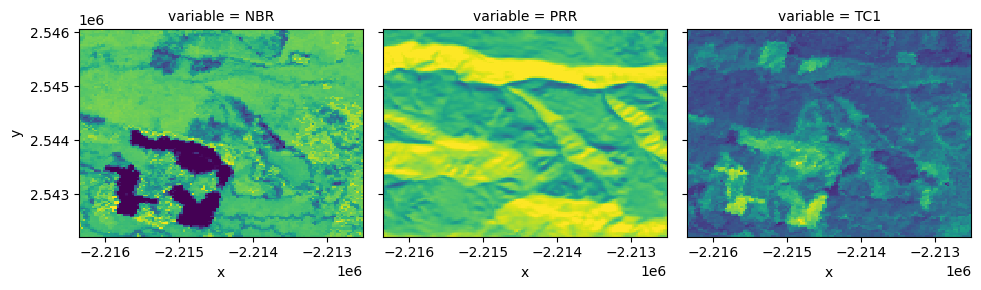

In [3]:
# Load normalized burn ratio, potential relative radiation, and tasseled cap brightness
preview = X_img[["NBR", "PRR", "TC1"]]
(preview / preview.max()).to_dataarray().plot(
    col="variable", add_colorbar=False, robust=True
)

### Plot Data

The second component is a dataframe of feature data, representing 3,005 plots with predictors that correspond to each of the raster bands.

In [4]:
X.head()

,ANNPRE,ANNTMP,AUGMAXT,CONTPRE,CVPRE,DECMINT,DIFTMP,SMRTMP,SMRTP,ASPTR,DEM,PRR,SLPPCT,TPI450,TC1,TC2,TC3,NBR
52481,740.0000,514.6667,2315.0000,517.6667,8971.6667,-583.1111,2899.1111,1136.1111,212.2222,197.6667,1870.1111,13196.6667,48.3333,33.7778,218.7778,68.5556,-86.2222,343.5556
52482,742.0000,563.5556,2354.3333,502.0000,9124.3333,-543.5556,2898.8889,1179.4444,221.1111,190.2222,1713.1111,16355.7778,5.4444,6.4444,210.2222,60.3333,-96.6667,261.6667
52484,738.5556,639.1111,2468.8889,545.8889,8897.2222,-479.1111,2949.0000,1266.2222,236.0000,194.5556,1612.1111,15132.5556,15.5556,-1.2222,157.0000,110.2222,-17.4444,721.0000
52485,730.3333,622.6667,2405.3333,555.0000,8829.7778,-481.2222,2887.5556,1244.2222,234.0000,196.4444,1682.3333,15146.6667,19.8889,-16.8889,152.5556,86.1111,-31.6667,597.1111
52494,720.0000,778.5556,2678.1111,658.5556,8638.0000,-386.6667,3065.7778,1396.0000,262.0000,191.7778,1345.6667,16672.1111,2.0000,0.4444,214.6667,58.5556,-88.1111,294.2222


## Building a PCA Pipeline

[PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis) is a common processing step to reduce data dimensionality while preserving information in a dataset. Because the magnitude of input features affects the PCA projection, it's important to scale the input data prior to transformation. We can accomplish both scaling and PCA transformation using a [pipeline](https://scikit-learn.org/stable/modules/compose.html) to stack the estimators. Just like other estimators, a pipeline can be wrapped with `wrap` prior to fitting to extend its methods to raster data.

In [5]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn_raster import wrap

pipeline = wrap(
    make_pipeline(
        StandardScaler(),
        PCA(n_components=3),
    )
)

pipeline.fit(X)

FeatureArrayEstimator(wrapped_estimator=Pipeline(steps=[('standardscaler',
                                                         StandardScaler()),
                                                        ('pca',
                                                         PCA(n_components=3))]))

Applying the pipeline's `transform` method to the multi-band raster dataset returns a dataset with one variable for each principal component, which can be plotted to visualize their spatial patterns.

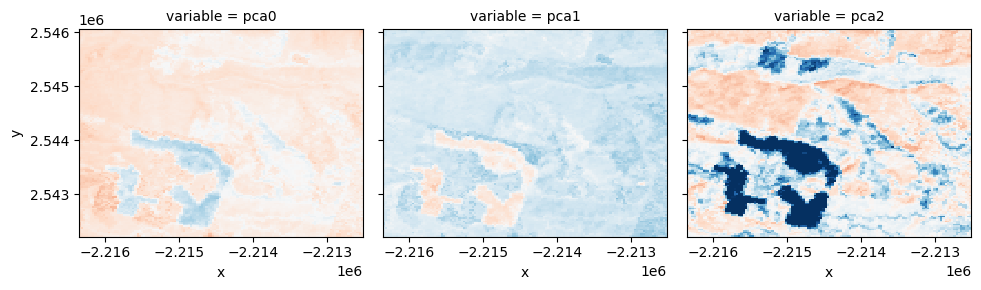

In [6]:
components = pipeline.transform(X_img)
components.to_dataarray().plot(col="variable", robust=True, add_colorbar=False)